This notebook reads in all the .csv files initially used in the New York City school attendance analysis along with location data for each school, and combines them all into one big .csv data file and outputs it for easier analysis into a visualization software.

The datasets may have more or less school DBNs than other datasets, so the number of unique DBNs will be documented for each dataset.

The datasets are outlined below:

2018-2021_Daily_Attendance_by_School.csv - Eduardo
    Lists attendance data for schools from Sept 2018 to March 2020
    https://data.cityofnewyork.us/Education/2018-2021-Daily-Attendance-by-School/xc44-2jrh

2019-20_Students_In_Temporary_Housing.csv - Erin
    Students in temporary housing
    https://data.cityofnewyork.us/Education/2019-20-Students-In-Temporary-Housing/ec4f-sy8r

City_Council_January_2021_Attendance.csv - Andrea
    Shows attendance rate for remote and blended learning students
    https://data.cityofnewyork.us/Education/City-Council-January-2021-Attendance/hsst-tgws/data

Learning_Preference_City_Remote_Learning_-_as_of_Jan_4__2021.csv - Andrea
    Total enrollement count for students whose learning preference is remote or blended
    https://data.cityofnewyork.us/Education/Learning-Preference-City-Remote-Learning-as-of-Jan/k5d2-tkrr

2020-2021_Demographic_Snapshot_School.csv - Grant
    Citywide student enrollment and demographic informatin from the 2016-2017 school year to 2020-2021
    https://data.cityofnewyork.us/Education/2020-2021-Demographic-Snapshot-School/vmmu-wj3w


2019_-_2020_School_Locations.csv
    Shows latitude and longitude for schools
    https://data.cityofnewyork.us/Education/2019-2020-School-Locations/wg9x-4ke6
    

GGG_2018-2021_attendance_data_merged_final.csv
    Grant's output data that needs monthly average

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Looking at daily attendance data

In [214]:
attend_file = '../data/2018-2021_Daily_Attendance_by_School.csv'
with open(attend_file) as f:
    attend_data = pd.read_csv(f, delimiter = ',')
    
attend_data.sample(5)

,School DBN,Date,SchoolYear,Enrolled,Present,Absent,Released
267572,05M670,04/30/2019,20182019,537,500,37,0
34911,10X051,10/25/2019,20192020,206,188,18,0
446363,27Q210,11/22/2019,20192020,1804,1693,111,0
88315,20K971,02/27/2020,20192020,297,286,11,0
88175,32K349,11/07/2019,20192020,297,269,28,0


In [215]:
# rename system_code to school_dbn to match other dataframe
col_rename_dict = {
    'School DBN': 'DBN'
}

# rename column
attend_data.rename(columns = col_rename_dict, inplace = True)
display(attend_data.head(10))

,DBN,Date,SchoolYear,Enrolled,Present,Absent,Released
0,15K896,09/05/2018,20182019,14,14,0,0
1,15K896,09/06/2018,20182019,26,26,0,0
2,15K896,09/07/2018,20182019,26,25,1,0
3,15K896,09/12/2018,20182019,27,26,1,0
4,15K896,09/13/2018,20182019,28,27,1,0
5,15K896,09/14/2018,20182019,29,27,2,0
6,15K896,09/17/2018,20182019,29,28,1,0
7,15K896,09/18/2018,20182019,30,29,1,0
8,15K896,09/20/2018,20182019,30,28,2,0
9,15K896,09/21/2018,20182019,30,29,1,0


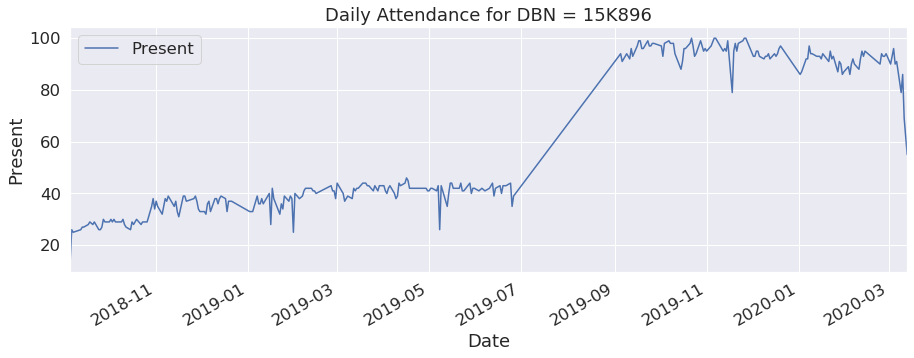

In [310]:
ax = attend_data[attend_data['DBN'] == '15K896'].plot.line(
    x = 'Date', 
    y = 'Present', 
    figsize = (15,5), 
    title = 'Daily Attendance for DBN = 15K896'
)
ax.set_ylabel('Present')

ax.figure.savefig('DBN_15K896_daily_present.png')

In [216]:
attend_data.info()
print(attend_data['DBN'].drop_duplicates().count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456170 entries, 0 to 456169
Data columns (total 7 columns):
DBN           456170 non-null object
Date          456170 non-null object
SchoolYear    456170 non-null int64
Enrolled      456170 non-null int64
Present       456170 non-null int64
Absent        456170 non-null int64
Released      456170 non-null int64
dtypes: int64(5), object(2)
memory usage: 24.4+ MB
1579


~456k rows, 1579 unique DBNs

## Aggregate data and calculate monthly average

In [217]:
# extract month from daily attendance data

# replace date with datetime format
attend_data['Date'] = pd.to_datetime(attend_data['Date'])

# create a month column, and undo the indexing
attend_data = attend_data.set_index('Date')  # set date to index
attend_data['month'] = attend_data.index.to_period('M')  # get date into yyyy-mm format and set to new column
attend_data = attend_data.reset_index()

In [218]:
# group by month and DBN
grouped_attendance = attend_data.set_index(['month', 'DBN'])
grouped_attendance = grouped_attendance.groupby(['month', 'DBN'])
#display(grouped_attendance.head(10))

# calculate averages by month and DBN
avg_enrolled = grouped_attendance['Enrolled'].mean()
avg_present = grouped_attendance['Present'].mean()
avg_absent = grouped_attendance['Absent'].mean()
avg_released = grouped_attendance['Released'].mean()
#display(avg_enrolled.head(10))

# unpack average data
unpacked_enrolled = avg_enrolled.reset_index()
unpacked_present = avg_present.reset_index()
unpacked_absent = avg_absent.reset_index()
unpacked_released = avg_released.reset_index()

#display(unpacked_enrolled.head(10))
#unpacked_enrolled[unpacked_enrolled['DBN'] == '01M015']

In [219]:
# merge average data into new dataframe
monthly_attendance = unpacked_enrolled.merge(unpacked_present, on = ['month', 'DBN'])
monthly_attendance = monthly_attendance.merge(unpacked_absent, on = ['month', 'DBN'])
monthly_attendance = monthly_attendance.merge(unpacked_released, on = ['month', 'DBN'])

# rename columns to indicate average quantities
col_rename_dict = {
    'Enrolled': 'avg_month_enrolled',
    'Present': 'avg_month_present',
    'Absent': 'avg_month_absent',
    'Released': 'avg_month_released'
}

# rename columns, inplace=True to overwrite exisiting df
monthly_attendance.rename(columns = col_rename_dict, inplace = True)
#display(monthly_attendance.head(10))

monthly_attendance[monthly_attendance['DBN'] == '15K896']

,month,DBN,avg_month_enrolled,avg_month_present,avg_month_absent,avg_month_released
774,2018-09,15K896,27.933333,26.466667,1.466667,0.000000
2351,2018-10,15K896,31.090909,29.727273,1.363636,0.000000
3928,2018-11,15K896,39.777778,36.111111,3.666667,0.000000
5505,2018-12,15K896,39.333333,36.133333,3.200000,0.000000
7082,2019-01,15K896,41.380952,35.761905,4.952381,0.666667
8659,2019-02,15K896,43.214286,40.642857,2.571429,0.000000
10236,2019-03,15K896,45.650000,41.550000,4.100000,0.000000
11813,2019-04,15K896,45.812500,42.062500,3.750000,0.000000
13390,2019-05,15K896,44.181818,41.000000,2.409091,0.772727
14967,2019-06,15K896,45.000000,41.400000,3.600000,0.000000


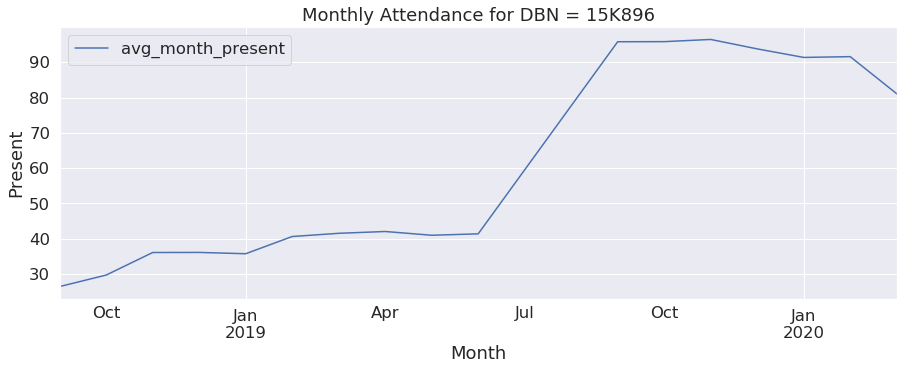

In [311]:
ax = monthly_attendance[monthly_attendance['DBN'] == '15K896'].plot.line(
    x = 'month', 
    y = 'avg_month_present', 
    figsize = (15,5), 
    title = 'Monthly Attendance for DBN = 15K896'
)
ax.set_xlabel('Month')
ax.set_ylabel('Present')

ax.figure.savefig('DBN_15K896_monthly_present.png')

In [220]:
monthly_attendance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26816 entries, 0 to 26815
Data columns (total 6 columns):
month                 26816 non-null period[M]
DBN                   26816 non-null object
avg_month_enrolled    26816 non-null float64
avg_month_present     26816 non-null float64
avg_month_absent      26816 non-null float64
avg_month_released    26816 non-null float64
dtypes: float64(4), object(1), period[M](1)
memory usage: 1.4+ MB


output the above for aggregated data by monthly average

# Calculating Percent Difference in Attendance for Last Two Months

In [221]:
# get all DBN and calculate percent difference between last two months
unique_dbn = monthly_attendance['DBN'].unique()
#print(all_dbn[0], all_dbn[-1])

all_dbn = []
percent_difference = []

for dbn in unique_dbn:
#    print(dbn)
#    print(monthly_attendance[monthly_attendance['DBN'] == dbn])
    enrollment = monthly_attendance[monthly_attendance['DBN'] == dbn]['avg_month_enrolled']
#    print(enrollment)

    # second to last minus last, all over second to last
    diff = (enrollment.iloc[-2] - enrollment.iloc[-1]) / enrollment.iloc[-2] * 100

    all_dbn.append(dbn)
    percent_difference.append(diff)

,DBN,percent_difference
0,01M015,0.903506
1,01M019,-0.895564
2,01M020,1.066083
3,01M034,-0.756534
4,01M063,0.819672
...,...,...
1574,75X721,0.168624
1575,75X754,-0.716127
1576,75X811,-0.094132
1577,13K915,-0.376471


2.875605815831989 -7.293825113966008


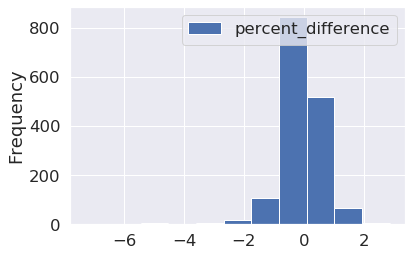

In [222]:
# make a new dataframe
dbn_attend_diff = pd.DataFrame(list(zip(all_dbn, percent_difference)), columns = ['DBN', 'percent_difference'])
display(dbn_attend_diff)

print(dbn_attend_diff['percent_difference'].max(), dbn_attend_diff['percent_difference'].min())
dbn_attend_diff.plot.hist(bins = 11)

In the above, positive percentages mean an average decrease from Feb 2020 to March 2020, negative percentages mean an increase. So there are more increases than decreases in attendance. Maybe there is a correlation between schools that increased attendance and income level or something.

# Looking at students in temporary housing data

In [223]:
temp_housing_file = '../data/2019-20_Students_In_Temporary_Housing.csv'
with open(temp_housing_file) as f:
    temp_housing_data = pd.read_csv(f, delimiter = ',')
    
temp_housing_data.sample(10)

,DBN,School Name,# Total Students,# Students in Temporary Housing,% Students in Temporary Housing,# Students Residing in Shelter,# Residing in DHS Shelter,# Residing in Non-DHS Shelter,# Doubled Up
1580,32K116,P.S. 116 Elizabeth L Farrell,351,83,23.6%,6,s,s,77
1099,22K444,Home Schooling,499,19,3.8%,s,s,s,17
991,20K180,The SEEALL Academy,1073,33,3.1%,s,s,s,26
62,02M217,P.S./I.S. 217 Roosevelt Island,675,9,1.3%,s,s,s,9
352,08X069,P.S. 069 Journey Prep School,627,66,10.5%,19,10,9,35
371,08X293,Renaissance High School for Musical Theater an...,455,20,4.4%,8,s,s,11
208,04M146,P.S. 146 Ann M. Short,415,116,28.0%,58,45,13,58
1645,75Q255,P.S. Q255,428,7,1.6%,s,s,s,s
517,10X279,"P.S. 279 Captain Manuel Rivera, Jr.",969,295,30.4%,45,37,8,247
1515,31R019,P.S. 019 The Curtis School,571,20,3.5%,9,s,s,11


In [224]:
temp_housing_data.info()
print(temp_housing_data['DBN'].drop_duplicates().count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 9 columns):
DBN                                1687 non-null object
School Name                        1687 non-null object
# Total Students                   1687 non-null int64
# Students in Temporary Housing    1687 non-null object
% Students in Temporary Housing    1687 non-null object
# Students Residing in Shelter     1687 non-null object
# Residing in DHS Shelter          1687 non-null object
# Residing in Non-DHS Shelter      1687 non-null object
# Doubled Up                       1687 non-null object
dtypes: int64(1), object(8)
memory usage: 118.7+ KB
1687


1687 rows, 1687 unique DBNs

# Looking at January 2021 attendance data

In [225]:
jan_attend_file = '../data/City_Council_January_2021_Attendance.csv'
with open(jan_attend_file) as f:
    jan_attend_data = pd.read_csv(f, delimiter = ',')
    
jan_attend_data.sample(10)

,DBN,School Name,Overall Attendance Rate,Remote Students Online Attendance Rate,Blended Students Overall Attendance Rate,Blended Students In-Person Attendance Rate,Blended Students Online Attendance Rate
612,12X129,M.S. 129 Academy for Independent Learning and ...,89.4,88.8,91.4,NaN,91.4
928,19K663,School of the Future Brooklyn,79.8,77.7,84.0,NaN,84.0
1218,26Q213,P.S. 213 The Carl Ullman School,97.4,96.9,98.7,96.8,98.8
561,11X127,J.H.S. 127 The Castle Hill,94.4,94.2,95.5,NaN,95.5
1481,31R048,P.S. 048 William G. Wilcox,94.2,94.6,93.6,97.8,92.5
944,20K112,P.S. 112 Lefferts Park,95.1,96.9,92.9,89.9,95.1
146,03M009,P.S. 009 Sarah Anderson,97.2,97.1,97.3,97.4,97.2
1179,25Q242,P.S. 242 Leonard P. Stavisky Early Childhood S...,98.0,98.3,97.5,97.7,92.8
314,07X298,Academy of Public Relations,89.9,88.7,93.1,NaN,93.1
1200,26Q046,P.S. 046 Alley Pond,97.6,98.8,96.0,95.7,96.2


In [226]:
jan_attend_data.info()
print(jan_attend_data['DBN'].drop_duplicates().count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 7 columns):
DBN                                           1608 non-null object
School Name                                   1608 non-null object
Overall Attendance Rate                       1608 non-null float64
Remote Students Online Attendance Rate        1608 non-null object
Blended Students Overall Attendance Rate      1608 non-null object
Blended Students In-Person Attendance Rate    924 non-null object
Blended Students Online Attendance Rate       1607 non-null object
dtypes: float64(1), object(6)
memory usage: 88.1+ KB
1608


1608 rows, 1608 unique DBNs

# Looking at learning preference data

In [227]:
learn_preference_file = '../data/Learning_Preference_City_Remote_Learning_-_as_of_Jan_4__2021.csv'
with open(learn_preference_file) as f:
    learn_preference_data = pd.read_csv(f, delimiter = ',')
    
learn_preference_data.head(20)

,District,Disaggregation Category,Category,# Total Enrollment,# Blended,% Blended,# Remote,% Remote
0,1,All District,All District,10549,"3,035",28.8%,7514,71.2%
1,1,English Language Learner Status,ELL,908,235,25.9%,673,74.1%
2,1,English Language Learner Status,Not ELL,9641,"2,800",29.0%,6841,71.0%
3,1,Gender,Female,5042,"1,455",28.9%,3587,71.1%
4,1,Gender,Male,5507,"1,580",28.7%,3927,71.3%
5,1,Grade Level,PK,366,173,47.3%,193,52.7%
6,1,Grade Level,0K,727,337,46.4%,390,53.6%
7,1,Grade Level,01,762,301,39.5%,461,60.5%
8,1,Grade Level,02,742,251,33.8%,491,66.2%
9,1,Grade Level,03,784,281,35.8%,503,64.2%


this data is split by district only

In [228]:
learn_preference_data.info()
print(learn_preference_data['District'].drop_duplicates().count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 8 columns):
District                   876 non-null int64
Disaggregation Category    876 non-null object
Category                   876 non-null object
# Total Enrollment         876 non-null int64
# Blended                  876 non-null object
% Blended                  876 non-null object
# Remote                   876 non-null object
% Remote                   876 non-null object
dtypes: int64(2), object(6)
memory usage: 54.9+ KB
34


876 rows, 34 unique districts

# Looking at demographic data

In [229]:
demographic_file = '../data/2020-2021_Demographic_Snapshot_School.csv'
with open(demographic_file) as f:
    demographic_data = pd.read_csv(f, delimiter = ',')
    
demographic_data.head()

,DBN,School Name,Year,Total Enrollment,Grade 3K+PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,...,% White,# Missing Race/Ethnicity Data,% Missing Race/Ethnicity Data,# Students with Disabilities,% Students with Disabilities,# English Language Learners,% English Language Learners,# Poverty,% Poverty,Economic Need Index
0,01M015,P.S. 015 Roberto Clemente,2016-17,178,17,28,33,27,31,24,...,0.022,0,0.0,51,0.287,12,0.067,152,85.4%,88.2%
1,01M015,P.S. 015 Roberto Clemente,2017-18,190,17,28,32,33,23,31,...,0.032,0,0.0,49,0.258,8,0.042,161,84.7%,89.0%
2,01M015,P.S. 015 Roberto Clemente,2018-19,174,13,20,33,30,30,20,...,0.034,0,0.0,39,0.224,8,0.046,147,84.5%,88.8%
3,01M015,P.S. 015 Roberto Clemente,2019-20,190,14,29,28,38,33,29,...,0.047,0,0.0,46,0.242,17,0.089,155,81.6%,86.7%
4,01M015,P.S. 015 Roberto Clemente,2020-21,193,17,29,29,27,30,32,...,0.057,0,0.0,43,0.223,21,0.109,158,81.9%,85.6%


In [230]:
demographic_data.info()
print(demographic_data['DBN'].drop_duplicates().count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9169 entries, 0 to 9168
Data columns (total 43 columns):
DBN                                  9169 non-null object
School Name                          9169 non-null object
Year                                 9169 non-null object
Total Enrollment                     9169 non-null int64
Grade 3K+PK (Half Day & Full Day)    9169 non-null int64
Grade K                              9169 non-null int64
Grade 1                              9169 non-null int64
Grade 2                              9169 non-null int64
Grade 3                              9169 non-null int64
Grade 4                              9169 non-null int64
Grade 5                              9169 non-null int64
Grade 6                              9169 non-null int64
Grade 7                              9169 non-null int64
Grade 8                              9169 non-null int64
Grade 9                              9169 non-null int64
Grade 10                           

9169 rows, 1879 unique DBNs

## Combine demographic categories into combined columns

In [231]:
# get relevant columns from the data frame, and apply a lambda function to join them as strings, then convert to a list with split()
demographic_data['Grade PK, K, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12'] = demographic_data[demographic_data.columns[4:18]].apply(lambda x: ','.join(x.astype(str)).split(), axis = 1)

demographic_data['#Female, #Male'] = demographic_data[demographic_data.columns[[18, 20]]].apply(lambda x: ','.join(x.astype(str)).split(), axis = 1)
demographic_data['%Female, %Male'] = demographic_data[demographic_data.columns[[19, 21]]].apply(lambda x: ','.join(x.astype(str)).split(), axis = 1)

demographic_data['#Asian, #Black, #Hispanic, #MultiRacial, #Native, #White, #Missing'] = demographic_data[demographic_data.columns[[22, 24, 26, 28, 30, 32, 34]]].apply(lambda x: ','.join(x.astype(str)).split(), axis = 1)
demographic_data['%Asian, %Black, %Hispanic, %MultiRacial, %Native, %White, %Missing'] = demographic_data[demographic_data.columns[[23, 25, 27, 29, 31, 33, 35]]].apply(lambda x: ','.join(x.astype(str)).split(), axis = 1)

demographic_data.head()

,DBN,School Name,Year,Total Enrollment,Grade 3K+PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,...,# English Language Learners,% English Language Learners,# Poverty,% Poverty,Economic Need Index,"Grade PK, K, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12","#Female, #Male","%Female, %Male","#Asian, #Black, #Hispanic, #MultiRacial, #Native, #White, #Missing","%Asian, %Black, %Hispanic, %MultiRacial, %Native, %White, %Missing"
0,01M015,P.S. 015 Roberto Clemente,2016-17,178,17,28,33,27,31,24,...,12,0.067,152,85.4%,88.2%,"[17,28,33,27,31,24,18,0,0,0,0,0,0,0]","[83,95]","[0.466,0.534]","[14,51,105,3,1,4,0]","[0.079,0.287,0.59,0.017,0.006,0.02200000000000..."
1,01M015,P.S. 015 Roberto Clemente,2017-18,190,17,28,32,33,23,31,...,8,0.042,161,84.7%,89.0%,"[17,28,32,33,23,31,26,0,0,0,0,0,0,0]","[99,91]","[0.521,0.479]","[20,52,110,1,1,6,0]","[0.105,0.27399999999999997,0.579,0.005,0.005,0..."
2,01M015,P.S. 015 Roberto Clemente,2018-19,174,13,20,33,30,30,20,...,8,0.046,147,84.5%,88.8%,"[13,20,33,30,30,20,28,0,0,0,0,0,0,0]","[85,89]","[0.489,0.511]","[24,48,95,0,1,6,0]","[0.138,0.276,0.546,0.0,0.006,0.034,0.0]"
3,01M015,P.S. 015 Roberto Clemente,2019-20,190,14,29,28,38,33,29,...,17,0.089,155,81.6%,86.7%,"[14,29,28,38,33,29,19,0,0,0,0,0,0,0]","[94,96]","[0.495,0.505]","[27,56,96,0,2,9,0]","[0.142,0.295,0.505,0.0,0.011000000000000001,0...."
4,01M015,P.S. 015 Roberto Clemente,2020-21,193,17,29,29,27,30,32,...,21,0.109,158,81.9%,85.6%,"[17,29,29,27,30,32,29,0,0,0,0,0,0,0]","[101,92]","[0.523,0.47700000000000004]","[26,53,102,1,0,11,0]","[0.135,0.275,0.528,0.005,0.0,0.057,0.0]"


# Look at location data

In [232]:
location_file = '../data/2019_-_2020_School_Locations.csv'
with open(location_file) as f:
    location_data = pd.read_csv(f, delimiter = ',')
    
location_data.sample(5)

,fiscal_year,system_code,location_code,location_name,BEDS,Managed_by_name,location_type_description,Location_Category_Description,Grades_text,Grades_final_text,...,Administrative_District_Name,community_school_sup_name,Tier_3_Support_Location_Name,Tier_3_Support_Leader_Name,Tier_2_Support_Location_Name,HighSchool_Network_Location_Code,HighSchool_Network_Name,HighSchool_Network_Superintendent,Community_district 1,Police_precinct
426,2020,17K489,K489,W.E.B. Dubois Academic High School,331700011489,DOE,Transfer School,High school,"09,10,11,12","09,10,11,12",...,NaN,NaN,NaN,NaN,NaN,HS10,HS Network 10 Superintendent Office,"ROTONDO, PAUL",309.0,71.0
2178,2020,84X704,X704,KIPP Academy Charter School,320700860820,Charter,General Academic,K-12 all grades,"0K,01,02,03,04,05,06,07,08,09,10,11,12","0K,01,02,03,04,05,06,07,08,09,10,11,12",...,OFFICE OF CHARTER SCHOOLS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,44.0
1201,2020,24Q073,Q073,I.S. 73 - The Frank Sansivieri Intermediate Sc...,342400010073,DOE,General Academic,Junior High-Intermediate-Middle,"06,07,08,SE","06,07,08",...,COMMUNITY SCHOOL DISTRICT 24,"CHAN, MADELENE",NYCDOE Borough Office - Queens North,"PISACANO, MARY",School Support Team 4- Queens North,NaN,NaN,NaN,405.0,104.0
742,2020,04M072,M072,The Lexington Academy,310400010072,DOE,General Academic,K-8,"PK,0K,01,02,03,04,05,06,07,08,SE","PK,0K,01,02,03,04,05,06,07,08",...,COMMUNITY SCHOOL DISTRICT 04,"ESTRELLA, ALEXANDRA",NYCDOE Borough Office - Manhattan,"CHU, YUET",School Support Team 6- Manhattan,NaN,NaN,NaN,111.0,23.0
1089,2020,02M580,M580,Richard R. Green High School of Teaching,310200011580,DOE,General Academic,High school,"09,10,11,12,SE","09,10,11,12",...,NaN,NaN,NYCDOE Borough Office - Manhattan,"CHU, YUET",School Support Team 2- Manhattan,HS04,HS Network 04 Superintendent Office,"ORLEN, VIVIAN",101.0,1.0


In [233]:
location_data.info()
print(location_data['system_code'].drop_duplicates().count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 41 columns):
fiscal_year                          2190 non-null int64
system_code                          2190 non-null object
location_code                        2190 non-null object
location_name                        2190 non-null object
BEDS                                 2190 non-null int64
Managed_by_name                      2190 non-null object
location_type_description            2190 non-null object
Location_Category_Description        2190 non-null object
Grades_text                          2103 non-null object
Grades_final_text                    2102 non-null object
open_date                            2190 non-null object
Status_descriptions                  2190 non-null object
Primary_building_code                2190 non-null object
primary_address_line_1               2190 non-null object
State_code                           2190 non-null object
X_COORDINATE             

2190 rows, 2131 unique DBNs

A summary of the data sets is shown below: <br>

file, identifier, nRows, nUniqueIdentifier <br>
2018-2021_Daily_Attendance_by_School.csv, schoolDBN, ~456k, 1579 <br>
2019-20_Students_In_Temporary_Housing.csv, schoolDBN, 1687, 1687 <br>
City_Council_January_2021_Attendance.csv, schoolDBN, 1608, 1608 <br>
Learning_Preference_City_Remote_Learning_-_as_of_Jan_4__2021.csv, district, 876, 34 <br>
2020-2021_Demographic_Snapshot_School.csv, schoolDBN, 9169, 1879 <br>
2019_-_2020_School_Locations.csv, schoolDBN, 2190, 2131

In [234]:
# extract relevant data from location file

# only get system_code, school name, lat, and long
school_latlong = location_data[['system_code', 'location_name', 'LATITUDE', 'LONGITUDE']].drop_duplicates().dropna()

# rename system_code to DBN to match other dataframe
col_rename_dict = {
    'system_code': 'DBN',
    'location_name': 'School Name',
    'LATITUDE': 'latitude',
    'LONGITUDE': 'longitude'
}

# rename columns, inplace=True to overwrite exisiting df
school_latlong.rename(columns = col_rename_dict, inplace = True)

# split DBN into district, and borough
school_latlong['District'] = school_latlong['DBN'].str[0:2]
school_latlong['Borough'] = school_latlong['DBN'].str[2:3]

display(school_latlong.sample(5))

,DBN,School Name,latitude,longitude,District,Borough
52,75K053,P.S. K053,40.660805,-73.988743,75,K
598,23K697,Teachers Preparatory High School,40.665568,-73.912102,23,K
1793,07X184,I S 184 Rafael C Y Molina,40.818900,-73.905900,07,X
1964,11X370,Leaders of Tomorrow,40.880649,-73.860126,11,X
1904,08X304,P.S. 304 Early Childhood School,40.827080,-73.829211,08,X


In [235]:
school_latlong.info()  # 2130 unique DBNs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2188
Data columns (total 6 columns):
DBN            2130 non-null object
School Name    2130 non-null object
latitude       2130 non-null float64
longitude      2130 non-null float64
District       2130 non-null object
Borough        2130 non-null object
dtypes: float64(2), object(4)
memory usage: 116.5+ KB


In [236]:
# output school_latlong data to .csv
school_latlong.to_csv('school_latlong.csv', index = False)

# Look at Grant's output data

In [237]:
grant_file = '../data/GGG_2018-2021_attendance_data_merged_final.csv'
with open(grant_file) as f:
    grant_data = pd.read_csv(f, delimiter = ',')
    
grant_data.sample(5)

,District,Date,Overall Attendance Rate,Student Category 1,Student Category 2,Remote Students Online Attendance Rate,Blended Students Overall Attendance Rate,Blended Students In-Person Attendance Rate,Blended Students Online Attendance Rate,Remote Students Overall Attendance Rate,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
11620,30,2/1/21 0:00,92.6,Hispanic,Not STH,92.2,93.2,93.2,93.2,NaN,NaN,NaN,NaN,NaN,NaN
1614,3,2/1/21 0:00,92.7,Grade 11,Asian,93.2,89.9,NaN,89.9,NaN,NaN,NaN,NaN,NaN,NaN
11837,31,2/1/21 0:00,93.4,Grade 03,Multi-Racial,92.1,94.4,93.6,95.0,NaN,NaN,NaN,NaN,NaN,NaN
40354,7,10/1/21 0:00,s,Grade 05,Asian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16251,32,3/1/21 0:00,86.8,Grade 02,Black,88.9,83.5,85.6,80.6,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
grant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50531 entries, 0 to 50530
Data columns (total 15 columns):
District                                      50531 non-null int64
Date                                          50531 non-null object
Overall Attendance Rate                       50531 non-null object
Student Category 1                            50531 non-null object
Student Category 2                            50531 non-null object
Remote Students Online Attendance Rate        37055 non-null float64
Blended Students Overall Attendance Rate      36382 non-null float64
Blended Students In-Person Attendance Rate    33989 non-null float64
Blended Students Online Attendance Rate       36330 non-null float64
Remote Students Overall Attendance Rate       10245 non-null object
Unnamed: 10                                   0 non-null float64
Unnamed: 11                                   0 non-null float64
Unnamed: 12                                   0 non-null float64
Unnamed: 13  

In [239]:
# neglect unnamed columns
grant_attend = grant_data.drop(labels = ['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], axis = 1)
#grant_attend.info()

# convert overall attendance and remote student overall attendance to floats
grant_attend['Overall Attendance Rate'] = pd.to_numeric(grant_attend['Overall Attendance Rate'], errors = 'coerce') 
grant_attend['Remote Students Overall Attendance Rate'] = pd.to_numeric(grant_attend['Remote Students Overall Attendance Rate'], errors = 'coerce') 
#grant_attend.info()
# when converting, a lot of the values come out to be null

# replace date with datetime format
grant_attend['Date'] = pd.to_datetime(grant_data['Date'])

# extract month
grant_attend = grant_attend.set_index('Date')
grant_attend['Month'] = grant_attend.index.to_period('M')
grant_attend = grant_attend.reset_index()
grant_attend.sample(5)

,Date,District,Overall Attendance Rate,Student Category 1,Student Category 2,Remote Students Online Attendance Rate,Blended Students Overall Attendance Rate,Blended Students In-Person Attendance Rate,Blended Students Online Attendance Rate,Remote Students Overall Attendance Rate,Month
28665,2021-04-01,17,85.1,STH Not in Shelters,Not in Shelters,83.7,90.1,92.1,86.4,NaN,2021-04
46875,2021-10-01,24,97.0,Grade 04,Multi-Racial,NaN,NaN,NaN,NaN,NaN,2021-10
20839,2021-03-01,23,100.0,Grade 11,Ethnicity Not Reported,100.0,NaN,NaN,NaN,NaN,2021-03
42563,2021-10-01,13,89.9,Male,Not in Shelters,NaN,NaN,NaN,NaN,78.4,2021-10
42359,2021-10-01,12,NaN,Grade 10,Ethnicity Not Reported,NaN,NaN,NaN,NaN,NaN,2021-10


In [240]:
# group by month and district
grouped_grant_attend = grant_attend.set_index(['Month', 'District'])
grouped_grant_attend = grouped_grant_attend.groupby(['Month', 'District'])
display(grouped_grant_attend.head(10))

Date  Overall Attendance Rate Student Category 1  \
Month   District                                                          
2018-09 1        2018-09-01                90.704865       All Students   
2018-10 1        2018-10-01                90.784046       All Students   
2018-11 1        2018-11-01                88.723449       All Students   
2018-12 1        2018-12-01                88.868290       All Students   
2019-01 1        2019-01-01                87.157345       All Students   
...                     ...                      ...                ...   
2021-10 75       2021-10-01                82.200000       All Students   
        75       2021-10-01                81.000000       All Students   
        75       2021-10-01                82.400000       All Students   
        75       2021-10-01                82.000000       All Students   
        75       2021-10-01                82.900000       All Students   

                 Student Category 2  Remote Students Online Attendance Rate  \
Month   District                                                              
2018-09 1              All Students                                     NaN   
2018-10 1              All Students                                     NaN   
2018-11 1              All Students                                     NaN   
2018-12 1              All Students                                     NaN   
2019-01 1              All Students                                     NaN   
...                             ...                                     ...   
2021-10 75                 Grade 0K                                     NaN   
        75                 Grade 01                                     NaN   
        75                 Grade 02                                     NaN   
        75                 Grade 03                                     NaN   
        75                 Grade 04                                     NaN   

                  Blended Students Overall Attendance Rate  \
Month   District                                             
2018-09 1                                              NaN   
2018-10 1                                              NaN   
2018-11 1                                              NaN   
2018-12 1                                              NaN   
2019-01 1                                              NaN   
...                                                    ...   
2021-10 75                                             NaN   
        75                                             NaN   
        75                                             NaN   
        75                                             NaN   
        75                                             NaN   

                  Blended Students In-Person Attendance Rate  \
Month   District                                               
2018-09 1                                                NaN   
2018-10 1                                                NaN   
2018-11 1                                                NaN   
2018-12 1                                                NaN   
2019-01 1                                                NaN   
...                                                      ...   
2021-10 75                                               NaN   
        75                                               NaN   
        75                                               NaN   
        75                                               NaN   
        75                                               NaN   

                  Blended Students Online Attendance Rate  \
Month   District                                            
2018-09 1                                             NaN   
2018-10 1                                             NaN   
2018-11 1                                             NaN   
2018-12 1                                             NaN   
2019-01 1    

In [241]:
# calculate averages by month and district
avg_overall = grouped_grant_attend['Overall Attendance Rate'].mean()
avg_remote_online = grouped_grant_attend['Remote Students Online Attendance Rate'].mean()
avg_blended_overall = grouped_grant_attend['Blended Students Overall Attendance Rate'].mean()
avg_blended_inperson = grouped_grant_attend['Blended Students In-Person Attendance Rate'].mean()
avg_blended_online = grouped_grant_attend['Blended Students Online Attendance Rate'].mean()
avg_remote_overall = grouped_grant_attend['Remote Students Overall Attendance Rate'].mean()

#avg_blended_overall[avg_blended_overall.isnull() == False]

In [242]:
# unpack average data
unpack_avg_overall = avg_overall.reset_index()
unpack_avg_remote_online = avg_remote_online.reset_index()
unpack_avg_blended_overall = avg_blended_overall.reset_index()
unpack_avg_blended_inperson = avg_blended_inperson.reset_index()
unpack_avg_blended_online = avg_blended_online.reset_index()
unpack_avg_remote_overall = avg_remote_overall.reset_index()

#unpack_avg_blended_overall[unpack_avg_blended_overall['Blended Students Overall Attendance Rate'].isnull() == False]

In [243]:
# merge average data into new dataframe
grant_monthly_attendance = unpack_avg_overall.merge(unpack_avg_remote_online, on = ['Month', 'District'])
grant_monthly_attendance = grant_monthly_attendance.merge(unpack_avg_blended_overall, on = ['Month', 'District'])
grant_monthly_attendance = grant_monthly_attendance.merge(unpack_avg_blended_inperson, on = ['Month', 'District'])
grant_monthly_attendance = grant_monthly_attendance.merge(unpack_avg_blended_online, on = ['Month', 'District'])
grant_monthly_attendance = grant_monthly_attendance.merge(unpack_avg_remote_overall, on = ['Month', 'District'])

#grant_montly_attendance[grant_montly_attendance['Blended Students Overall Attendance Rate'].isnull() == False]

In [244]:
# rename columns
column_rename = {
    'Overall Attendance Rate': 'Monthly Average Overall Attendance Rate', 
    'Remote Students Online Attendance Rate': 'Monthly Average Remote Students Online Attendance Rate', 
    'Blended Students Overall Attendance Rate': 'Monthly Average Blended Students Overall Attendance Rate', 
    'Blended Students In-Person Attendance Rate': 'Monthly Average Blended Students In-Person Attendance Rate', 
    'Blended Students Online Attendance Rate': 'Monthly Average Blended Students Online Attendance Rate', 
    'Remote Students Overall Attendance Rate': 'Monthly Average Remote Students Overall Attendance Rate'
}
grant_monthly_attendance.rename(columns = column_rename, inplace = True)
display(grant_monthly_attendance)

,Month,District,Monthly Average Overall Attendance Rate,Monthly Average Remote Students Online Attendance Rate,Monthly Average Blended Students Overall Attendance Rate,Monthly Average Blended Students In-Person Attendance Rate,Monthly Average Blended Students Online Attendance Rate,Monthly Average Remote Students Overall Attendance Rate
0,2018-09,1,90.704865,NaN,NaN,NaN,NaN,NaN
1,2018-09,2,91.773065,NaN,NaN,NaN,NaN,NaN
2,2018-09,3,92.565806,NaN,NaN,NaN,NaN,NaN
3,2018-09,4,92.838423,NaN,NaN,NaN,NaN,NaN
4,2018-09,5,89.586456,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
826,2021-10,29,86.858491,NaN,NaN,NaN,NaN,87.199558
827,2021-10,30,89.615691,NaN,NaN,NaN,NaN,83.066023
828,2021-10,31,87.934908,NaN,NaN,NaN,NaN,86.431683
829,2021-10,32,88.759403,NaN,NaN,NaN,NaN,93.753333


In [245]:
# write out grant attendance to .csv
grant_monthly_attendance.to_csv('all_monthly_attendance.csv', index = False)

# Combining datasets

In [246]:
housing_and_jan = temp_housing_data.merge(jan_attend_data, on = ['DBN', 'School Name'])
#housing_and_jan.info()  # 1594 rows

demographic_merge = housing_and_jan.merge(demographic_data, on = ['DBN', 'School Name'])
#demographic_merge.info()  # 7931 rows

#attendance_merge = demographic_merge.merge(attend_data, on = 'DBN')
##attendance_merge.info()  # 2.26 mill rows

# instead of full daily attednance merge, merge aggregated monthly attendance
attendance_merge = demographic_merge.merge(monthly_attendance, on = 'DBN')
#attendance_merge.info()  # 132k rows

location_merge = attendance_merge.merge(school_latlong, on = ['DBN', 'School Name'])
#location_merge.info()  # 132k rows, used to be 2.25 mill rows

In [247]:
location_merge.sample(10)

,DBN,School Name,# Total Students,# Students in Temporary Housing,% Students in Temporary Housing,# Students Residing in Shelter,# Residing in DHS Shelter,# Residing in Non-DHS Shelter,# Doubled Up,Overall Attendance Rate,...,"%Asian, %Black, %Hispanic, %MultiRacial, %Native, %White, %Missing",month,avg_month_enrolled,avg_month_present,avg_month_absent,avg_month_released,latitude,longitude,District,Borough
57997,14K031,P.S. 031 Samuel F. Dupont,625,149,23.8%,9,s,s,140,96.7,...,"[0.09300000000000001,0.046,0.41700000000000004...",2019-12,610.266667,573.533333,36.733333,0.000000,40.726970,-73.954139,14,K
120396,31R011,P.S. 11 Thomas Dongan School,340,14,4.1%,s,s,s,8,88.1,...,"[0.081,0.17800000000000002,0.387,0.00900000000...",2019-02,309.642857,286.642857,20.428571,2.571429,40.590887,-74.098252,31,R
35471,09X263,Validus Preparatory Academy,355,59,16.6%,23,9,14,33,81.7,...,"[0.003,0.336,0.652,0.003,0.003,0.0,0.003]",2019-06,346.777778,239.333333,107.333333,0.111111,40.839508,-73.901774,09,X
62562,15K169,P.S. 169 Sunset Park,1302,103,7.9%,7,s,s,85,96.6,...,"[0.5660000000000001,0.013000000000000001,0.376...",2019-02,1389.928571,1325.142857,64.785714,0.000000,40.645825,-74.001700,15,K
30001,08X293,Renaissance High School for Musical Theater an...,455,20,4.4%,8,s,s,11,80.1,...,"[0.032,0.249,0.63,0.0,0.006,0.077,0.004]",2019-12,431.933333,350.600000,81.000000,0.333333,40.839775,-73.839583,08,X
60683,14K610,A-Tech High School,309,22,7.1%,13,s,s,9,82.2,...,"[0.036000000000000004,0.401,0.501,0.003,0.021,...",2019-12,303.800000,249.800000,53.933333,0.066667,40.721448,-73.953328,14,K
54359,12X691,Bronx Little School,334,57,17.1%,s,s,s,47,94.6,...,"[0.141,0.17800000000000002,0.6409999999999999,...",2019-09,314.823529,300.058824,14.764706,0.000000,40.838151,-73.866038,12,X
96434,25Q163,P.S. 163 Flushing Heights,831,12,1.4%,s,s,s,11,97.6,...,"[0.813,0.01,0.153,0.011000000000000001,0.002,0...",2019-12,808.733333,771.866667,36.866667,0.000000,40.741107,-73.808765,25,Q
53675,12X480,Bronx Regional High School,197,44,22.3%,16,s,s,19,36.0,...,"[0.022000000000000002,0.37200000000000005,0.59...",2019-03,167.750000,105.400000,62.350000,0.000000,40.823124,-73.898265,12,X
25504,07X151,J.H.S. 151 Lou Gehrig,199,65,32.7%,19,s,s,43,92.8,...,"[0.0,0.268,0.705,0.0,0.004,0.023,0.0]",2019-01,228.523810,203.904762,24.619048,0.000000,40.822574,-73.921140,07,X


In [248]:
# split DBN into district, and borough
location_merge['District'] = location_merge['DBN'].str[0:2]
location_merge['Borough'] = location_merge['DBN'].str[2:3]
    
# replace borough symbols with names
replace_dict = {
    'K':'Brooklyn',
    'X':'Bronx',
    'Q':'Queens',
    'M':'Manhattan',
    'R':'Staten Island'
    }

location_merge.replace({'Borough':replace_dict}, inplace = True)

In [249]:
location_merge.sample(10)

,DBN,School Name,# Total Students,# Students in Temporary Housing,% Students in Temporary Housing,# Students Residing in Shelter,# Residing in DHS Shelter,# Residing in Non-DHS Shelter,# Doubled Up,Overall Attendance Rate,...,"%Asian, %Black, %Hispanic, %MultiRacial, %Native, %White, %Missing",month,avg_month_enrolled,avg_month_present,avg_month_absent,avg_month_released,latitude,longitude,District,Borough
57077,13K594,Gotham Professional Arts Academy,160,20,12.5%,13,7,6,6,79.6,...,"[0.013000000000000001,0.789,0.191,0.0,0.0,0.00...",2019-05,163.318182,135.409091,27.545455,0.363636,40.678591,-73.961636,13,Brooklyn
92704,24Q119,P.S./I.S. 119 The Glendale,1332,50,3.8%,s,s,s,42,98.2,...,"[0.294,0.016,0.298,0.012,0.008,0.371,0.0]",2019-03,1277.050000,1230.550000,46.500000,0.000000,40.705187,-73.875073,24,Queens
66625,16K688,The Brooklyn Academy of Global Finance,129,12,9.3%,10,s,s,s,87.3,...,"[0.059000000000000004,0.7040000000000001,0.185...",2019-02,105.714286,91.857143,13.857143,0.000000,40.691467,-73.932254,16,Brooklyn
68701,17K375,P.S. 375 Jackie Robinson School,315,70,22.2%,20,s,s,49,82.9,...,"[0.04,0.616,0.293,0.002,0.012,0.03700000000000...",2019-04,346.437500,320.312500,23.937500,2.187500,40.665199,-73.959484,17,Brooklyn
13458,03M191,The Riverside School for Makers and Artists,565,74,13.1%,31,20,11,34,85.5,...,"[0.07400000000000001,0.303,0.434,0.01399999999...",2019-10,531.200000,499.750000,31.350000,0.100000,40.772200,-73.990902,03,Manhattan
67501,17K138,P.S. 138 Brooklyn,548,80,14.6%,54,40,14,26,83.0,...,"[0.018000000000000002,0.813,0.109,0.012,0.008,...",2020-01,530.476190,481.523810,48.952381,0.000000,40.673943,-73.951559,17,Brooklyn
117504,30Q204,I.S. 204 Oliver W. Holmes,447,55,12.3%,15,8,7,37,94.6,...,"[0.159,0.16699999999999998,0.603,0.002,0.004,0...",2018-12,454.866667,421.133333,33.733333,0.000000,40.756471,-73.932628,30,Queens
94551,24Q485,Grover Cleveland High School,1707,136,8.0%,14,s,s,118,75.0,...,"[0.1,0.057999999999999996,0.636,0.002,0.008,0....",2018-09,1711.200000,1411.600000,298.066667,1.533333,40.711881,-73.909202,24,Queens
5389,02M260,The Clinton School,778,13,1.7%,s,s,s,9,94.6,...,"[0.127,0.04,0.124,0.037000000000000005,0.00699...",2018-09,720.866667,707.066667,13.800000,0.000000,40.736526,-73.992727,02,Manhattan
3987,02M126,P.S. 126 Jacob August Riis,726,170,23.4%,7,s,s,163,97.0,...,"[0.644,0.092,0.171,0.035,0.0,0.057999999999999...",2019-06,715.600000,679.266667,36.333333,0.000000,40.710651,-73.997420,02,Manhattan


In [250]:
# make learn_preference district column into a string 
learn_preference = learn_preference_data.astype('str')

#location_merge.info()
#print(type(location_merge['District'][0]))
#print(type(learn_preference['District'][1]))


all_data = location_merge
#all_data = location_merge.merge(learn_preference, on = 'District')
#all_data.info()  # 2.25 mill rows

In [251]:
# write out huge data to .csv
all_data.to_csv('all_data.csv', index = False)

## Try looking at all_data more in-depth

In [252]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132546 entries, 0 to 132545
Data columns (total 69 columns):
DBN                                                                   132546 non-null object
School Name                                                           132546 non-null object
# Total Students                                                      132546 non-null int64
# Students in Temporary Housing                                       132546 non-null object
% Students in Temporary Housing                                       132546 non-null object
# Students Residing in Shelter                                        132546 non-null object
# Residing in DHS Shelter                                             132546 non-null object
# Residing in Non-DHS Shelter                                         132546 non-null object
# Doubled Up                                                          132546 non-null object
Overall Attendance Rate                              

In [253]:
# make dataframe for analysis
analysis_df = pd.DataFrame()

analysis_df['Month'] = all_data['month']
analysis_df['DBN'] = all_data['DBN']
analysis_df['School Name'] = all_data['School Name']
analysis_df['District'] = all_data['District']
analysis_df['Borough'] = all_data['Borough']
analysis_df['Average Monthly Absences'] = all_data['avg_month_absent']
analysis_df['Average Monthly Releases'] = all_data['avg_month_released']
analysis_df['% Asian'] = all_data['% Asian'] * 100
analysis_df['% Black'] = all_data['% Black'] * 100
analysis_df['% Hispanic'] = all_data['% Hispanic'] * 100
analysis_df['% Multi-Racial'] = all_data['% Multi-Racial'] * 100
analysis_df['% Native American'] = all_data['% Native American'] * 100
analysis_df['% White'] = all_data['% White'] * 100
analysis_df['% Missing Race/Ethnicity Data'] = all_data['% Missing Race/Ethnicity Data'] * 100
analysis_df['% Poverty'] = all_data['% Poverty']
analysis_df['Economic Need Index'] = all_data['Economic Need Index']
analysis_df = analysis_df.drop_duplicates()

# handle strings and convert to floats
analysis_df['% Poverty'].replace(to_replace = 'Below 5%', value = '4.9%', inplace = True)
analysis_df['% Poverty'].replace(to_replace = 'Above 95%', value = '95.1%', inplace = True)
analysis_df['% Poverty'] = analysis_df['% Poverty'].str.rstrip('%').astype('float')

analysis_df['Economic Need Index'].replace(to_replace = 'Below 5%', value = '4.9%', inplace = True)
analysis_df['Economic Need Index'].replace(to_replace = 'Above 95%', value = '95.1%', inplace = True)
analysis_df['Economic Need Index'] = analysis_df['Economic Need Index'].str.rstrip('%').astype('float')


analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132478 entries, 0 to 132545
Data columns (total 16 columns):
Month                            132478 non-null period[M]
DBN                              132478 non-null object
School Name                      132478 non-null object
District                         132478 non-null object
Borough                          132478 non-null object
Average Monthly Absences         132478 non-null float64
Average Monthly Releases         132478 non-null float64
% Asian                          132478 non-null float64
% Black                          132478 non-null float64
% Hispanic                       132478 non-null float64
% Multi-Racial                   132478 non-null float64
% Native American                132478 non-null float64
% White                          132478 non-null float64
% Missing Race/Ethnicity Data    132478 non-null float64
% Poverty                        132478 non-null float64
Economic Need Index              132

Text(0, 0.5, 'Percent Absent')

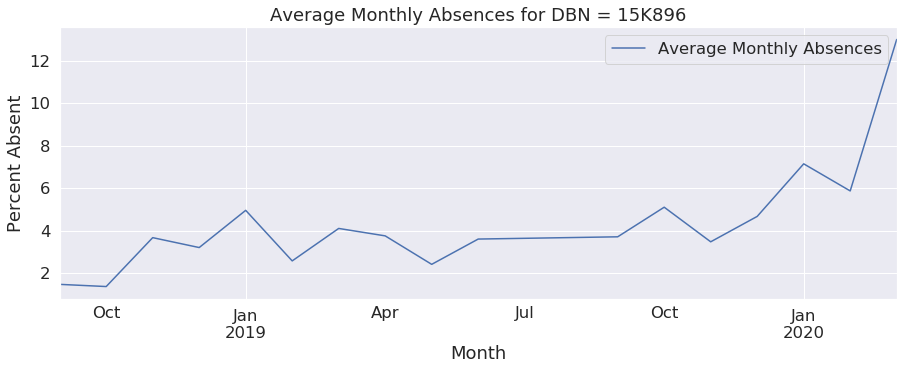

In [312]:
# plot attendance
#thing = analysis_df[analysis_df['DBN'] == '03M417'].sort_values('Month')
#thing.plot.line(x = 'Month', y = 'Average Monthly Absences')

ax = analysis_df[analysis_df['DBN'] == '15K896'].sort_values('Month').plot.line(
    x = 'Month', 
    y = 'Average Monthly Absences', 
    figsize = (15,5), 
    title = 'Average Monthly Absences for DBN = 15K896'
)
ax.set_xlabel('Month')
ax.set_ylabel('Percent Absent')

#ax.figure.savefig('DBN_15K896_monthly_present.png')

## Clean up data to only include demographic data from the last year available

In [255]:
# clean up all data to only include:
# dbn, school name, district, borough, total enrollment(maybe), gender (labels), gender values, race (label), race values, disabilities, ELL, poverty
# 
# only include last year of demographic data
# pivot values should be of the form:
# Gender | Value
# Male | 27%
# Female | 30%
# so probably several rows for a single DBN

In [256]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132546 entries, 0 to 132545
Data columns (total 69 columns):
DBN                                                                   132546 non-null object
School Name                                                           132546 non-null object
# Total Students                                                      132546 non-null int64
# Students in Temporary Housing                                       132546 non-null object
% Students in Temporary Housing                                       132546 non-null object
# Students Residing in Shelter                                        132546 non-null object
# Residing in DHS Shelter                                             132546 non-null object
# Residing in Non-DHS Shelter                                         132546 non-null object
# Doubled Up                                                          132546 non-null object
Overall Attendance Rate                              

In [257]:
all_data['Year'].drop_duplicates()

0     2016-17
17    2017-18
34    2018-19
51    2019-20
68    2020-21
Name: Year, dtype: object

In [258]:
temp_df = all_data[all_data['Year'] == '2020-21']
temp_df

,DBN,School Name,# Total Students,# Students in Temporary Housing,% Students in Temporary Housing,# Students Residing in Shelter,# Residing in DHS Shelter,# Residing in Non-DHS Shelter,# Doubled Up,Overall Attendance Rate,...,"%Asian, %Black, %Hispanic, %MultiRacial, %Native, %White, %Missing",month,avg_month_enrolled,avg_month_present,avg_month_absent,avg_month_released,latitude,longitude,District,Borough
68,01M015,P.S. 015 Roberto Clemente,193,70,36.3%,29,21,8,38,86.4,...,"[0.135,0.275,0.528,0.005,0.0,0.057,0.0]",2018-09,173.133333,162.533333,10.600000,0.000000,40.722075,-73.978747,01,Manhattan
69,01M015,P.S. 015 Roberto Clemente,193,70,36.3%,29,21,8,38,86.4,...,"[0.135,0.275,0.528,0.005,0.0,0.057,0.0]",2018-10,171.000000,161.636364,9.363636,0.000000,40.722075,-73.978747,01,Manhattan
70,01M015,P.S. 015 Roberto Clemente,193,70,36.3%,29,21,8,38,86.4,...,"[0.135,0.275,0.528,0.005,0.0,0.057,0.0]",2018-11,173.444444,158.277778,15.166667,0.000000,40.722075,-73.978747,01,Manhattan
71,01M015,P.S. 015 Roberto Clemente,193,70,36.3%,29,21,8,38,86.4,...,"[0.135,0.275,0.528,0.005,0.0,0.057,0.0]",2018-12,173.733333,160.533333,13.200000,0.000000,40.722075,-73.978747,01,Manhattan
72,01M015,P.S. 015 Roberto Clemente,193,70,36.3%,29,21,8,38,86.4,...,"[0.135,0.275,0.528,0.005,0.0,0.057,0.0]",2019-01,174.190476,157.714286,15.952381,0.523810,40.722075,-73.978747,01,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132541,75X811,P.S. X811,642,66,10.3%,35,22,13,25,78.0,...,"[0.046,0.314,0.591,0.0,0.02,0.0289999999999999...",2019-11,639.235294,531.176471,106.352941,1.705882,40.830552,-73.886798,75,Bronx
132542,75X811,P.S. X811,642,66,10.3%,35,22,13,25,78.0,...,"[0.046,0.314,0.591,0.0,0.02,0.0289999999999999...",2019-12,639.600000,529.733333,107.266667,2.600000,40.830552,-73.886798,75,Bronx
132543,75X811,P.S. X811,642,66,10.3%,35,22,13,25,78.0,...,"[0.046,0.314,0.591,0.0,0.02,0.0289999999999999...",2020-01,639.142857,519.761905,111.571429,7.809524,40.830552,-73.886798,75,Bronx
132544,75X811,P.S. X811,642,66,10.3%,35,22,13,25,78.0,...,"[0.046,0.314,0.591,0.0,0.02,0.0289999999999999...",2020-02,637.400000,537.533333,98.133333,1.733333,40.830552,-73.886798,75,Bronx


In [259]:
# handle 'Above 95%' string
temp_df['% Poverty'].drop_duplicates()
temp_df['% Poverty'].replace(to_replace = 'Above 95%', value = '95.1%', inplace = True)

thing = temp_df['% Poverty'].str.rstrip('%').astype('float')
thing.drop_duplicates()

/usr/lib/python3/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


68        81.9
153       71.2
238       70.9
323       95.1
408       76.9
          ... 
124828    45.9
125168    41.6
125253    60.7
128398    88.9
128908    44.9
Name: % Poverty, Length: 519, dtype: float64

## Pivot demographic data

In [260]:
demographic_df = pd.DataFrame()

demographic_df['DBN'] = temp_df['DBN']

demographic_df['Asian'] = temp_df['% Asian'] * 100
demographic_df['Black'] = temp_df['% Black'] * 100
demographic_df['Hispanic'] = temp_df['% Hispanic'] * 100
demographic_df['Multi-Racial'] = temp_df['% Multi-Racial'] * 100
demographic_df['Native American'] = temp_df['% Native American'] * 100
demographic_df['White'] = temp_df['% White'] * 100
demographic_df['Missing Race/Ethnicity Data'] = temp_df['% Missing Race/Ethnicity Data'] * 100

demographic_df = demographic_df.drop_duplicates()
demographic_df.head(18)

,DBN,Asian,Black,Hispanic,Multi-Racial,Native American,White,Missing Race/Ethnicity Data
68,01M015,13.5,27.5,52.8,0.5,0.0,5.7,0.0
153,01M019,6.1,19.3,61.3,3.3,0.5,8.0,1.4
238,01M020,24.8,13.3,52.2,1.5,0.7,7.3,0.2
323,01M034,2.6,38.1,55.7,0.4,0.4,2.9,0.0
408,01M063,2.9,19.2,63.5,3.4,0.5,9.1,1.4
493,01M064,3.2,18.2,72.7,0.9,0.5,4.1,0.5
578,01M110,15.8,10.7,43.7,1.9,0.3,27.3,0.3
663,01M134,9.7,26.3,60.4,1.4,0.9,1.4,0.0
748,01M140,2.0,21.2,72.9,0.0,0.3,3.6,0.0
833,01M142,0.3,18.0,76.3,0.6,1.6,2.2,0.9


In [261]:
demographic_pivot = pd.DataFrame()

demographic_pivot = demographic_df.melt(id_vars = 'DBN', var_name = 'Race', value_name = 'Race Percentage')
demographic_pivot[1500:1600]

,DBN,Race,Race Percentage
1500,32K377,Asian,0.0
1501,32K383,Asian,3.2
1502,32K384,Asian,1.2
1503,32K403,Asian,1.2
1504,32K545,Asian,1.3
...,...,...,...
1595,02M003,Black,6.2
1596,02M006,Black,1.9
1597,02M011,Black,7.1
1598,02M033,Black,16.9


## Pivot Gender Data

In [262]:
gender_df = pd.DataFrame()

gender_df['DBN'] = temp_df['DBN']
gender_df['Female'] = temp_df['% Female'] * 100
gender_df['Male'] = temp_df['% Male'] * 100

gender_df = gender_df.drop_duplicates()
gender_df.head(18)

,DBN,Female,Male
68,01M015,52.3,47.7
153,01M019,46.7,53.3
238,01M020,48.8,51.2
323,01M034,46.2,53.8
408,01M063,47.6,52.4
493,01M064,44.1,55.9
578,01M110,42.9,57.1
663,01M134,46.1,53.9
748,01M140,46.6,53.4
833,01M142,43.2,56.8


In [263]:
gender_pivot = pd.DataFrame()

gender_pivot = gender_df.melt(id_vars = 'DBN', var_name = 'Gender', value_name = 'Gender Percentage')
gender_pivot[1500:1600]

,DBN,Gender,Gender Percentage
1500,32K377,Female,52.4
1501,32K383,Female,51.2
1502,32K384,Female,48.6
1503,32K403,Female,45.9
1504,32K545,Female,45.3
...,...,...,...
1595,02M003,Male,51.5
1596,02M006,Male,48.8
1597,02M011,Male,52.4
1598,02M033,Male,50.5


## Merge dataframes for compact dataframe

In [264]:
compact_df = pd.DataFrame()

compact_df['DBN'] = temp_df['DBN']
compact_df['School Name'] = temp_df['School Name']
compact_df['District'] = temp_df['District']
compact_df['Borough'] = temp_df['Borough']
compact_df['Total Enrollment'] = temp_df['Total Enrollment']
compact_df['% Students with Disabilities'] = temp_df['% Students with Disabilities'] * 100
compact_df['% English Language Learners'] = temp_df['% English Language Learners'] * 100
compact_df['% Poverty'] = temp_df['% Poverty'].str.rstrip('%').astype('float')

#compact_df['% Poverty'].dtype

compact_df = compact_df.drop_duplicates()

In [265]:
compact_df

,DBN,School Name,District,Borough,Total Enrollment,% Students with Disabilities,% English Language Learners,% Poverty
68,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9
153,01M019,P.S. 019 Asher Levy,01,Manhattan,212,39.2,4.2,71.2
238,01M020,P.S. 020 Anna Silver,01,Manhattan,412,21.8,11.9,70.9
323,01M034,P.S. 034 Franklin D. Roosevelt,01,Manhattan,273,39.2,6.2,95.1
408,01M063,The STAR Academy - P.S.63,01,Manhattan,208,27.9,1.4,76.9
...,...,...,...,...,...,...,...,...
132223,75X469,P469X - The Bronx School for Continuous Learners,75,Bronx,533,99.8,18.2,91.6
132274,75X596,P.S. X596,75,Bronx,409,100.0,11.7,78.2
132359,75X721,P.S. X721 - Stephen McSweeney School,75,Bronx,589,100.0,35.1,92.0
132444,75X754,J. M. Rapport School Career Development,75,Bronx,502,99.8,29.1,93.8


In [266]:
compact_data = compact_df.merge(gender_pivot, on = ['DBN'])
compact_data = compact_data.merge(demographic_pivot, on = ['DBN'])
compact_data.head(20)

,DBN,School Name,District,Borough,Total Enrollment,% Students with Disabilities,% English Language Learners,% Poverty,Gender,Gender Percentage,Race,Race Percentage
0,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Female,52.3,Asian,13.5
1,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Female,52.3,Black,27.5
2,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Female,52.3,Hispanic,52.8
3,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Female,52.3,Multi-Racial,0.5
4,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Female,52.3,Native American,0.0
5,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Female,52.3,White,5.7
6,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Female,52.3,Missing Race/Ethnicity Data,0.0
7,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Male,47.7,Asian,13.5
8,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Male,47.7,Black,27.5
9,01M015,P.S. 015 Roberto Clemente,01,Manhattan,193,22.3,10.9,81.9,Male,47.7,Hispanic,52.8


In [267]:
# write out compact demographic data to .csv
compact_data.to_csv('21-22_demographic_data.csv', index = False)

## Look at attendance and demographics more in-depth

In [268]:
# merge grant_monthly_attendance, compact_data for demographics, merge on district
grant_monthly_attendance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831 entries, 0 to 830
Data columns (total 8 columns):
Month                                                         831 non-null period[M]
District                                                      831 non-null int64
Monthly Average Overall Attendance Rate                       831 non-null float64
Monthly Average Remote Students Online Attendance Rate        204 non-null float64
Monthly Average Blended Students Overall Attendance Rate      204 non-null float64
Monthly Average Blended Students In-Person Attendance Rate    203 non-null float64
Monthly Average Blended Students Online Attendance Rate       204 non-null float64
Monthly Average Remote Students Overall Attendance Rate       33 non-null float64
dtypes: float64(6), int64(1), period[M](1)
memory usage: 58.4 KB


In [269]:
small_monthly_attendance = pd.DataFrame()

small_monthly_attendance['Month'] = grant_monthly_attendance['Month']
small_monthly_attendance['District'] = grant_monthly_attendance['District'].astype('str')
small_monthly_attendance['Average Monthly Attendance'] = grant_monthly_attendance['Monthly Average Overall Attendance Rate']

In [270]:
compact_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21924 entries, 0 to 21923
Data columns (total 12 columns):
DBN                             21924 non-null object
School Name                     21924 non-null object
District                        21924 non-null object
Borough                         21924 non-null object
Total Enrollment                21924 non-null int64
% Students with Disabilities    21924 non-null float64
% English Language Learners     21924 non-null float64
% Poverty                       21924 non-null float64
Gender                          21924 non-null object
Gender Percentage               21924 non-null float64
Race                            21924 non-null object
Race Percentage                 21924 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.2+ MB


In [271]:
demographics = pd.DataFrame()

demographics['DBN'] = compact_data['DBN']
demographics['District'] = compact_data['District']
demographics['Poverty'] = compact_data['% Poverty']
demographics = demographics.drop_duplicates()

# pivot race data
unpivoted_race_data = pd.DataFrame()
unpivoted_race_data['DBN'] = compact_data['DBN']
unpivoted_race_data['District'] = compact_data['District']
unpivoted_race_data['Race'] = compact_data['Race']
unpivoted_race_data['Race Percentage'] = compact_data['Race Percentage']
unpivoted_race_data = unpivoted_race_data.drop_duplicates()
#unpivoted_race_data

pivoted_race_data = unpivoted_race_data.pivot(index = 'DBN', columns = 'Race')['Race Percentage']

dummy_for_analysis = unpivoted_race_data.merge(pivoted_race_data, on = 'DBN')
dummy_for_analysis = dummy_for_analysis.drop(columns = ['Race', 'Race Percentage'])
dummy_for_analysis = dummy_for_analysis.drop_duplicates()
#dummy_for_analysis

demographics = demographics.merge(dummy_for_analysis, on = ['DBN', 'District'])
demographics.head()

,DBN,District,Poverty,Asian,Black,Hispanic,Missing Race/Ethnicity Data,Multi-Racial,Native American,White
0,01M015,01,81.9,13.5,27.5,52.8,0.0,0.5,0.0,5.7
1,01M019,01,71.2,6.1,19.3,61.3,1.4,3.3,0.5,8.0
2,01M020,01,70.9,24.8,13.3,52.2,0.2,1.5,0.7,7.3
3,01M034,01,95.1,2.6,38.1,55.7,0.0,0.4,0.4,2.9
4,01M063,01,76.9,2.9,19.2,63.5,1.4,3.4,0.5,9.1


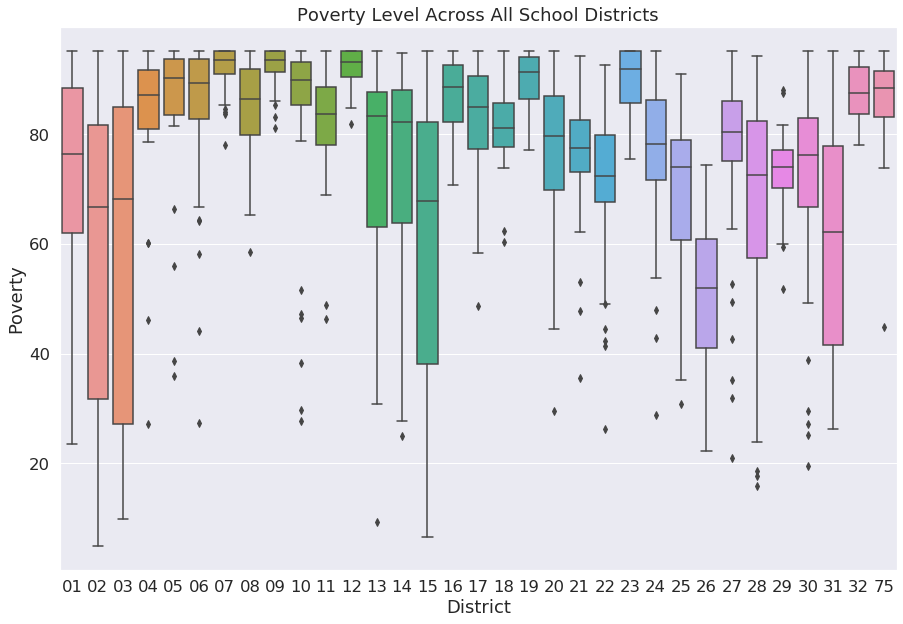

In [272]:
#sns.boxplot(x = demographics['District'], y = demographics['Poverty'])

plt.figure(figsize = (15,10))
sns.set(font_scale = 1.5)
ax = sns.boxplot(
    x = 'District', 
    y = 'Poverty', 
    data = demographics
).set(title = 'Poverty Level Across All School Districts')
plt.show()

In [273]:
# group demographics by district, calculate the average, and un-groupby
district_demographics = demographics.groupby('District').mean().reset_index()
district_demographics

,District,Poverty,Asian,Black,Hispanic,Missing Race/Ethnicity Data,Multi-Racial,Native American,White
0,01,72.133333,13.900000,18.362963,49.840741,0.303704,2.755556,0.585185,14.251852
1,02,56.479661,18.065254,16.283051,36.630508,1.052542,3.390678,0.622034,23.960169
2,03,58.527273,6.786364,25.402273,37.963636,1.152273,3.256818,0.622727,24.813636
3,04,82.475000,7.039286,24.746429,59.857143,0.403571,1.635714,1.064286,5.271429
4,05,84.440741,3.229630,48.348148,40.470370,0.674074,1.014815,0.948148,5.337037
5,06,84.473913,1.323913,6.110870,84.923913,0.243478,1.010870,0.269565,6.123913
6,07,92.095000,1.092500,26.245000,69.725000,0.145000,0.370000,0.935000,1.512500
7,08,85.029412,6.278431,22.531373,64.456863,0.119608,0.396078,1.254902,4.976471
8,09,92.526087,1.301449,26.923188,69.359420,0.120290,0.178261,0.659420,1.456522
9,10,86.213095,4.509524,16.025000,73.613095,0.235714,0.464286,1.003571,4.146429


In [274]:
# change single digit districts to double digit for nice merging
old_districts = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
new_districts = ['01', '02', '03', '04', '05', '06', '07', '08', '09']

small_monthly_attendance['District'] = small_monthly_attendance['District'].replace(to_replace = old_districts, value = new_districts)
small_monthly_attendance

# merge with attendance data
clean_monthly_attendance = small_monthly_attendance.merge(district_demographics, on = 'District')
clean_monthly_attendance

,Month,District,Average Monthly Attendance,Poverty,Asian,Black,Hispanic,Missing Race/Ethnicity Data,Multi-Racial,Native American,White
0,2018-09,01,90.704865,72.133333,13.900000,18.362963,49.840741,0.303704,2.755556,0.585185,14.251852
1,2018-10,01,90.784046,72.133333,13.900000,18.362963,49.840741,0.303704,2.755556,0.585185,14.251852
2,2018-11,01,88.723449,72.133333,13.900000,18.362963,49.840741,0.303704,2.755556,0.585185,14.251852
3,2018-12,01,88.868290,72.133333,13.900000,18.362963,49.840741,0.303704,2.755556,0.585185,14.251852
4,2019-01,01,87.157345,72.133333,13.900000,18.362963,49.840741,0.303704,2.755556,0.585185,14.251852
...,...,...,...,...,...,...,...,...,...,...,...
820,2021-04,75,81.862637,86.698182,9.649091,35.387273,39.785455,0.052727,0.943636,1.569091,12.618182
821,2021-05,75,83.232203,86.698182,9.649091,35.387273,39.785455,0.052727,0.943636,1.569091,12.618182
822,2021-06,75,81.169492,86.698182,9.649091,35.387273,39.785455,0.052727,0.943636,1.569091,12.618182
823,2021-09,75,75.062712,86.698182,9.649091,35.387273,39.785455,0.052727,0.943636,1.569091,12.618182


In [275]:
# get districts with highest and lowest poverty levels
#clean_monthly_attendance[clean_monthly_attendance['Poverty'] == clean_monthly_attendance['Poverty'].max()]  # 09, 92.5
clean_monthly_attendance[clean_monthly_attendance['Poverty'] == clean_monthly_attendance['Poverty'].min()]  # 26, 50.99

,Month,District,Average Monthly Attendance,Poverty,Asian,Black,Hispanic,Missing Race/Ethnicity Data,Multi-Racial,Native American,White
625,2018-09,26,96.076865,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
626,2018-10,26,96.206428,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
627,2018-11,26,94.892493,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
628,2018-12,26,94.648678,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
629,2019-01,26,94.374109,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
630,2019-02,26,94.266194,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
631,2019-03,26,94.749773,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
632,2019-04,26,95.077315,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
633,2019-05,26,94.873159,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848
634,2019-06,26,92.649004,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848


In [276]:
clean_monthly_attendance.sort_values('Poverty', ascending = True).head(50)

,Month,District,Average Monthly Attendance,Poverty,Asian,Black,Hispanic,Missing Race/Ethnicity Data,Multi-Racial,Native American,White
625,2018-09,26,96.076865,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
627,2018-11,26,94.892493,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
628,2018-12,26,94.648678,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
629,2019-01,26,94.374109,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
630,2019-02,26,94.266194,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
631,2019-03,26,94.749773,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
632,2019-04,26,95.077315,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
633,2019-05,26,94.873159,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
634,2019-06,26,92.649004,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848
635,2019-09,26,96.273148,50.993939,54.924242,9.584848,16.396970,0.333333,2.033333,1.148485,15.584848


In [277]:
# do t-test to see if there is a statistical significance to the attednance of the two districts
district09_attendance = clean_monthly_attendance[clean_monthly_attendance['District'] == '09']['Average Monthly Attendance']
district26_attendance = clean_monthly_attendance[clean_monthly_attendance['District'] == '26']['Average Monthly Attendance']

res = stats.ttest_ind(district09_attendance, district26_attendance, equal_var=True)
display(res)

Ttest_indResult(statistic=-9.28091808973275, pvalue=2.7495743897733384e-12)

In [278]:
district12_attendance = clean_monthly_attendance[clean_monthly_attendance['District'] == '12']['Average Monthly Attendance']

res = stats.ttest_ind(district09_attendance, district12_attendance, equal_var=True)
display(res)

Ttest_indResult(statistic=1.2728946146192754, pvalue=0.20918630802510138)

In [279]:
# do lots of t-tests all comparing to the district with least poverty, district 26
districts = list(clean_monthly_attendance['District'].unique())

district_pvals = []
for district in districts:
    comparison_district = clean_monthly_attendance[clean_monthly_attendance['District'] == district]['Average Monthly Attendance']
    poverty = float(clean_monthly_attendance[clean_monthly_attendance['District'] == district]['Poverty'][0:1])
    
    stat, p = stats.ttest_ind(district26_attendance, comparison_district)
    district_pvals.append([district, round(poverty, 1), round(p, 4)])
        
display(district_pvals)
# district 20 is the only one that is similar to 26

[['01', 72.1, 0.0],
 ['02', 56.5, 0.0],
 ['03', 58.5, 0.0],
 ['04', 82.5, 0.0],
 ['05', 84.4, 0.0],
 ['06', 84.5, 0.0],
 ['07', 92.1, 0.0],
 ['08', 85.0, 0.0],
 ['09', 92.5, 0.0],
 ['10', 86.2, 0.0],
 ['11', 82.1, 0.0],
 ['12', 92.3, 0.0],
 ['13', 73.1, 0.0],
 ['14', 75.6, 0.0],
 ['15', 58.7, 0.0],
 ['16', 86.8, 0.0],
 ['17', 83.1, 0.0],
 ['18', 81.0, 0.0],
 ['19', 89.7, 0.0],
 ['20', 76.8, 0.3358],
 ['21', 76.2, 0.0],
 ['22', 70.3, 0.0],
 ['23', 89.9, 0.0],
 ['24', 76.9, 0.0],
 ['25', 69.1, 0.0],
 ['26', 51.0, 1.0],
 ['27', 77.4, 0.0],
 ['28', 68.5, 0.0],
 ['29', 73.3, 0.0],
 ['30', 71.5, 0.0016],
 ['31', 60.7, 0.0],
 ['32', 87.6, 0.0],
 ['75', 86.7, 0.0]]

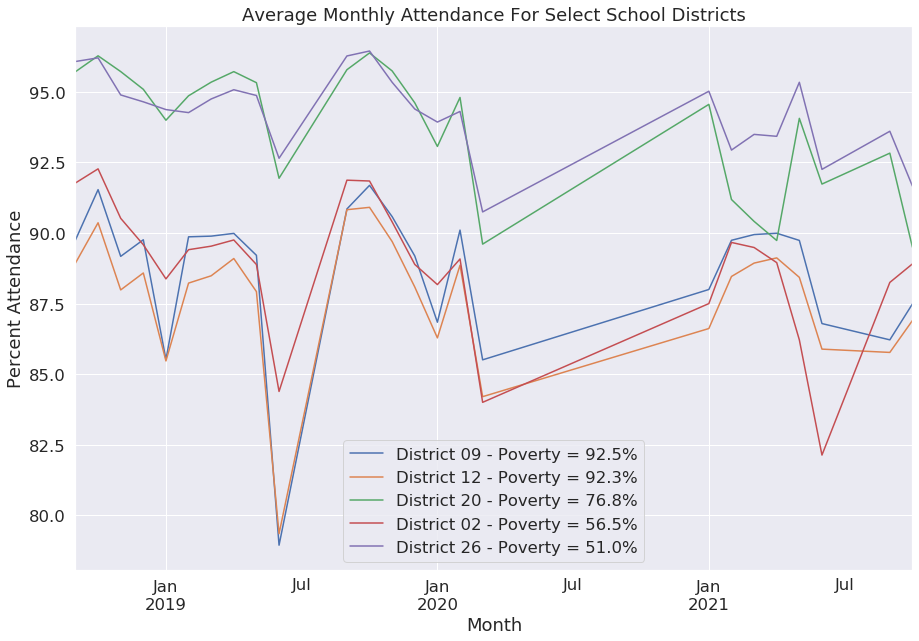

In [325]:
# plot attendance
plotting_attendance = pd.DataFrame()

plotting_attendance['Month'] = clean_monthly_attendance['Month'][0:25]  # to cut off other irrelevant rows
plotting_attendance['09'] = pd.Series(list(clean_monthly_attendance[clean_monthly_attendance['District'] == '09']['Average Monthly Attendance']))
plotting_attendance['12'] = pd.Series(list(clean_monthly_attendance[clean_monthly_attendance['District'] == '12']['Average Monthly Attendance']))
plotting_attendance['05'] = pd.Series(list(clean_monthly_attendance[clean_monthly_attendance['District'] == '05']['Average Monthly Attendance']))
plotting_attendance['20'] = pd.Series(list(clean_monthly_attendance[clean_monthly_attendance['District'] == '20']['Average Monthly Attendance']))
plotting_attendance['30'] = pd.Series(list(clean_monthly_attendance[clean_monthly_attendance['District'] == '30']['Average Monthly Attendance']))
plotting_attendance['02'] = pd.Series(list(clean_monthly_attendance[clean_monthly_attendance['District'] == '02']['Average Monthly Attendance']))
plotting_attendance['26'] = pd.Series(list(clean_monthly_attendance[clean_monthly_attendance['District'] == '26']['Average Monthly Attendance']))

ax = plotting_attendance.plot.line(
    x = 'Month', 
#    y = ['09', '12', '20', '30', '02', '26'], 
#    y = ['09', '12', '05', '20', '02', '26'], 
    y = ['09', '12', '20', '02', '26'], 
    figsize = (15,10), 
    title = 'Average Monthly Attendance For Select School Districts',
    label = [
        'District 09 - Poverty = 92.5%',
        'District 12 - Poverty = 92.3%',
#        'District 05 - Poverty = 84.4%',
        'District 20 - Poverty = 76.8%',
#        'District 30 - Poverty = 71.5%',
        'District 02 - Poverty = 56.5%',
        'District 26 - Poverty = 51.0%'
    ]
)
ax.set_ylabel('Percent Attendance')

ax.figure.savefig('poverty-attendance.png')

# Compare Attendance Rates from September 2018 and September 2021

average difference is: 4.183751806969696 %


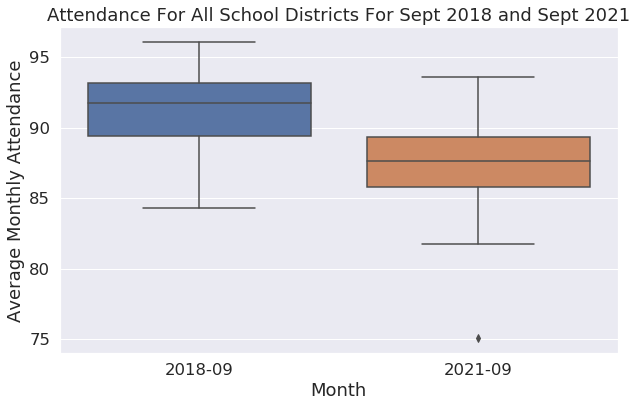

In [327]:
sept_18 = clean_monthly_attendance[clean_monthly_attendance['Month'] == '2018-09'][['Month', 'District', 'Average Monthly Attendance']]
sept_21 = clean_monthly_attendance[clean_monthly_attendance['Month'] == '2021-09'][['Month', 'District', 'Average Monthly Attendance']]
#sept_21

september_attendance = pd.concat([sept_18, sept_21])
september_attendance

difference = list(sept_18['Average Monthly Attendance']) - (sept_21['Average Monthly Attendance'])
print('average difference is:', difference.mean(), '%')


september_plot = plt.figure(figsize = (10,6))
sns.set(font_scale = 1.5)
ax = sns.boxplot(
    x = 'Month', 
    y = 'Average Monthly Attendance', 
    data = september_attendance
).set(title = 'Attendance For All School Districts For Sept 2018 and Sept 2021')
plt.show()

september_plot.savefig('sept-attendance-difference.png')

In [282]:
sept_18_attendance = sept_18['Average Monthly Attendance']
sept_21_attendance = sept_21['Average Monthly Attendance']

stat, p = stats.ttest_ind(sept_18_attendance, sept_21_attendance)
display(p)

8.353675259169897e-07

In [283]:
display(sept_18['Average Monthly Attendance'].describe())
display(sept_21['Average Monthly Attendance'].describe())
display(sept_18['Average Monthly Attendance'].mean() - sept_21['Average Monthly Attendance'].mean())

count    33.000000
mean     91.395084
std       2.551848
min      84.329827
25%      89.432821
50%      91.773065
75%      93.166597
max      96.076865
Name: Average Monthly Attendance, dtype: float64

count    33.000000
mean     87.211332
std       3.588645
min      75.062712
25%      85.770213
50%      87.643902
75%      89.315686
max      93.605882
Name: Average Monthly Attendance, dtype: float64

4.183751806969681

In [330]:
# find what the funny 75% attendance district is
sept_21[sept_21['Average Monthly Attendance'] == sept_21['Average Monthly Attendance'].min()]

,Month,District,Average Monthly Attendance
823,2021-09,75,75.062712


In [284]:
clean_monthly_attendance[clean_monthly_attendance['Average Monthly Attendance'] == 74.5092057]  # 05 has lowest attendance
#clean_monthly_attendance[clean_monthly_attendance['Average Monthly Attendance'] == 96.4488363]  # 26 has max attendance
#clean_monthly_attendance['Average Monthly Attendance'].min()

,Month,District,Average Monthly Attendance,Poverty,Asian,Black,Hispanic,Missing Race/Ethnicity Data,Multi-Racial,Native American,White


In [285]:
lowest_attendance = learn_preference_data[learn_preference_data['District'] == 5]
highest_attendance = learn_preference_data[learn_preference_data['District'] == 26]

lowest_attendance
#highest_attendance

,District,Disaggregation Category,Category,# Total Enrollment,# Blended,% Blended,# Remote,% Remote
104,5,All District,All District,9248,"2,514",27.2%,6734,72.8%
105,5,English Language Learner Status,ELL,786,290,36.9%,496,63.1%
106,5,English Language Learner Status,Not ELL,8462,"2,224",26.3%,6238,73.7%
107,5,Gender,Female,4278,"1,218",28.5%,3060,71.5%
108,5,Gender,Male,4970,"1,296",26.1%,3674,73.9%
109,5,Grade Level,PK,492,239,48.6%,253,51.4%
110,5,Grade Level,0K,494,221,44.7%,273,55.3%
111,5,Grade Level,01,563,246,43.7%,317,56.3%
112,5,Grade Level,02,573,219,38.2%,354,61.8%
113,5,Grade Level,03,578,201,34.8%,377,65.2%


/tmp/ipykernel_17885/1532208280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dist_attend['% Blended'] = all_dist_attend['% Blended'].str.rstrip('%').astype('float')
/tmp/ipykernel_17885/1532208280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dist_attend['% Remote'] = all_dist_attend['% Remote'].str.rstrip('%').astype('float')


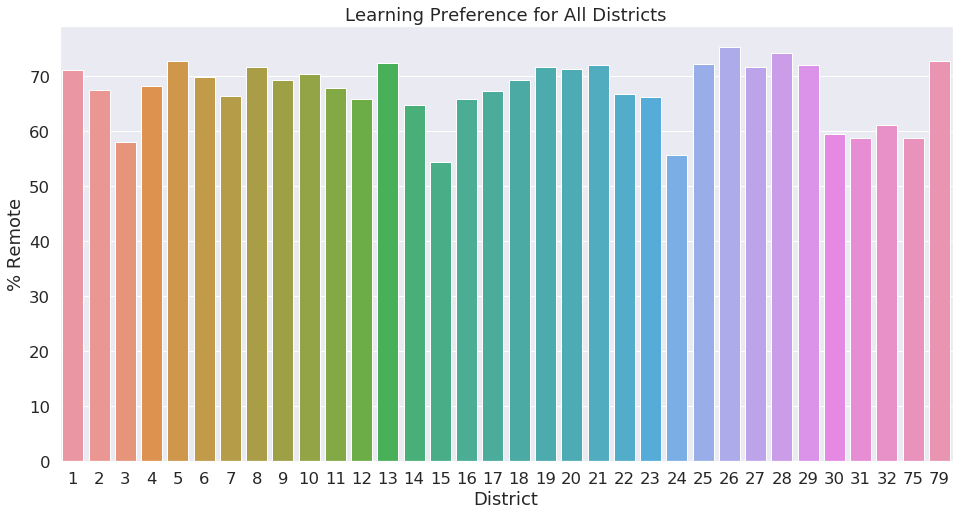

In [286]:
all_dist_attend = learn_preference_data[learn_preference_data['Disaggregation Category'] == 'All District']

all_dist_attend['% Blended'] = all_dist_attend['% Blended'].str.rstrip('%').astype('float')
all_dist_attend['% Remote'] = all_dist_attend['% Remote'].str.rstrip('%').astype('float')
#all_dist_attend



plt.figure(figsize = (16,8))
sns.set(font_scale = 1.5)
ax = sns.barplot(
    x = 'District', 
    y = '% Remote', 
    data = all_dist_attend
).set(title = 'Learning Preference for All Districts')
plt.show()


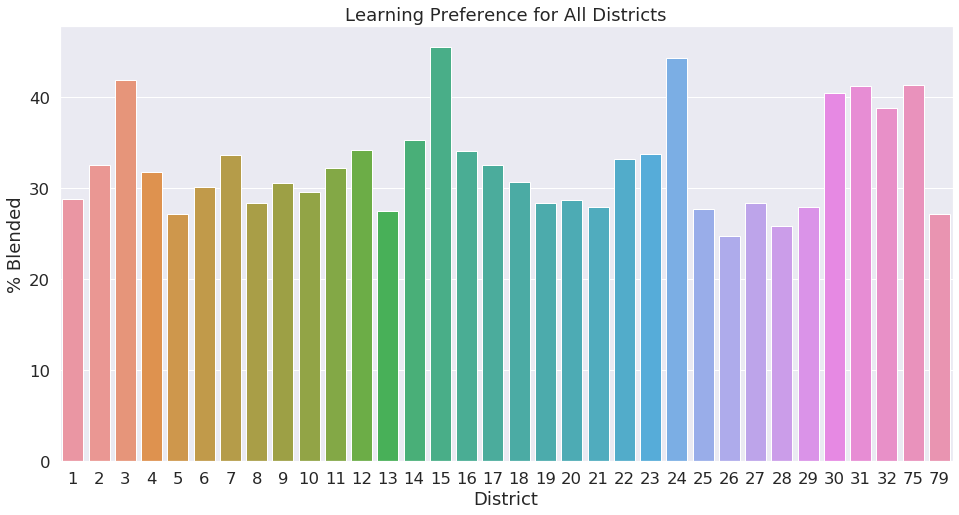

In [287]:
plt.figure(figsize = (16,8))
sns.set(font_scale = 1.5)
ax = sns.barplot(
    x = 'District', 
    y = '% Blended', 
    data = all_dist_attend
).set(title = 'Learning Preference for All Districts')
plt.show()

In [320]:
high_low_attendance = clean_monthly_attendance[(clean_monthly_attendance['District'] == '05') | (clean_monthly_attendance['District'] == '26')]
clean_high_low = high_low_attendance.drop(columns = ['Month', 'Average Monthly Attendance']).drop_duplicates()
display(clean_high_low)
# 05 low attendance
# 26 high attednance

,District,Poverty,Asian,Black,Hispanic,Missing Race/Ethnicity Data,Multi-Racial,Native American,White
100,05,84.440741,3.229630,48.348148,40.47037,0.674074,1.014815,0.948148,5.337037
625,26,50.993939,54.924242,9.584848,16.39697,0.333333,2.033333,1.148485,15.584848


In [321]:
nice_df = pd.melt(clean_high_low, id_vars = ['District'], value_vars = ['Asian', 'Black', 'Hispanic', 'Native American', 'White', 'Multi-Racial', 'Missing Race/Ethnicity Data'])

# rename columns
column_rename = {
    'variable': 'Race / Ethnicity', 
    'value': 'Percentage'
}
nice_df.rename(columns = column_rename, inplace = True)
nice_df

,District,Race / Ethnicity,Percentage
0,05,Asian,3.229630
1,26,Asian,54.924242
2,05,Black,48.348148
3,26,Black,9.584848
4,05,Hispanic,40.470370
5,26,Hispanic,16.396970
6,05,Native American,0.948148
7,26,Native American,1.148485
8,05,White,5.337037
9,26,White,15.584848


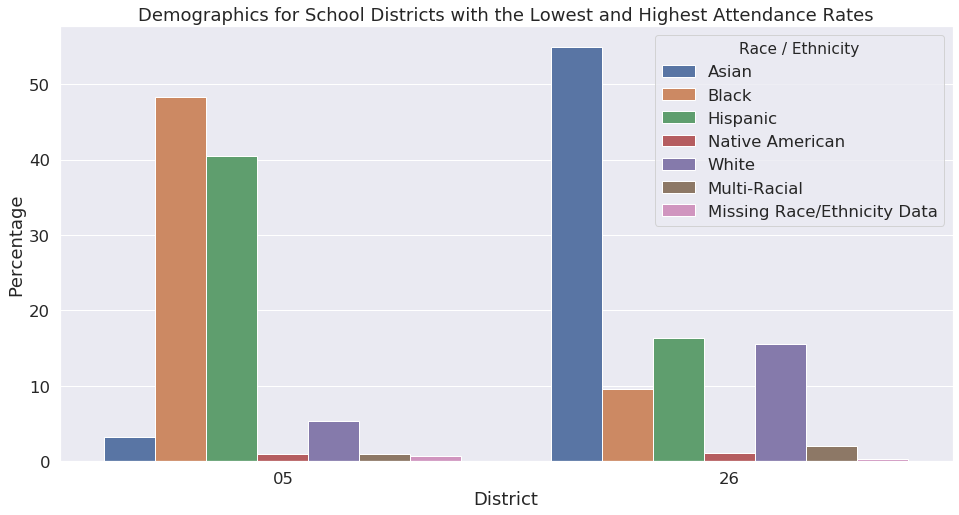

In [322]:
demographic_fig = plt.figure(figsize = (16,8))
sns.set(font_scale = 1.5)
ax = sns.barplot(
    x = 'District', 
    y = 'Percentage',
    hue = 'Race / Ethnicity',
    data = nice_df
).set(title = 'Demographics for School Districts with the Lowest and Highest Attendance Rates')
plt.show()

demographic_fig.savefig('demographics-for-high-and-low-attendance.png')